# Solution of the "Off-Diagonal" team

**Process Management Problem**

In the process management problem, we are given a set of tasks represented by processes $p$. Each process $p_i$ has an associated value $v_i$​ (indicating its importance) and a duration $d_i$​ (representing the time required to execute the task). Additionally, there exists a maximum allowed duration $d_{max}$​ within which we must execute these tasks.


Our objective is to select a subset $S$ of processes from $p$ such that their total duration does not exceed $d_{max}$​, while maximizing the overall value of the executed processes. In other words, we aim to find the set S that maximizes the expression:

$$\sum_{i\in S} v_i$$

subject to the constraint:

$$\sum_{i\in S} d_i \leq d_{max}$$

## Define problem instance

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Hackathon Tasks 


### Build the cost hamiltonians for the Process Management problem:

If there was no contraint of a maximum duration, the sum to maximize would simply be:

$$H_B=\sum_{i} v_i \cdot b_i $$

where $b_i$ is 1 if the task is selected and 0 if not. But to punish the selections of tasks which don't satisfy the contraint, we add another Hamiltonian $H_A$

Simply adding something like:

$$H_A=\left(\sum_{i=0}^{n-1}d_i b_i \right)^2$$

would not be enough, because [... complete explanation]

$$H_A=A*\left( \sum_{j=0}^{M-1} 2^j y_j + (c+1+2^M)y_M -\sum_{i=0}^{n-1}d_i b_i \right)^2$$

where $M$ is the log of the maximum duration (rouded down) and $y_i$ is the i-th helper qubit needed to evaluate perfectly if we don't satisfy the contraints. A is a constant which must be bigger than the maximum duration. [complete explanation]

This is a perfect implementation of the Knapsack problem, but it requires $n + log_2(d_{max})+1$ qubits.

In [3]:
from qibo.symbols import Z, X
from qibo.hamiltonians import SymbolicHamiltonian
import numpy as np
import math

def build_cost_hamiltonian(values: list[int], duration: list[int], max_duration: int) -> SymbolicHamiltonian:
    """This function should be filled to build the problem cost hamiltonian.

    Args:
        values (list[int]): the list of values.
        duration (list[int]): the list of durations. 
        max_duration (int): the maximum value of the allowed duration.
        
    """
    B=1
    A=max(values)+1
    M=math.floor(np.log2(max_duration)) #round down the log2 of the max duration
    n=len(values)
    H_A_not_squared = sum( np.power(2,j)*(1-Z(j+n))/2 for j in range(0,M)) + (max_duration+1-np.power(2,M))*(1-Z(M+n))/2 - sum(duration[i]*(1-Z(i))/2 for i in range(0,len(values)))
    H_A = A*H_A_not_squared*H_A_not_squared
    H_B= - B*sum(values[i]*(1-Z(i))/2 for i in range(0,len(values)))
    
    cost_hamiltonian = H_A+H_B
    
    return SymbolicHamiltonian(cost_hamiltonian)

### Compute the number fo qubits required to execute the cost hamiltonian

In [4]:
# define the number of qubits:
nqubits=math.floor(np.log2(max_duration)) + len(values)+1

### Diagonalize the cost hamiltonian and examen its eigenvalues and eigenvectors. 
- Show that the ground state eigenvector does actually correspond to the ground state energy of the problem. (Note: the ground state could be degenerate)

In [5]:
import numpy as np
from qibo import set_backend

# set the backend used for the calculation 
set_backend("numpy", platform=None)


# create the cost Hamiltonian for the given graph
cost_hamiltonian = build_cost_hamiltonian(values=values, duration=duration, max_duration=max_duration)

ham_matrix = cost_hamiltonian.matrix

eig_val, eig_vec = np.linalg.eig(ham_matrix)
eig_vec = ["{0:0{bits}b}".format(i.argmax(), bits=nqubits) for i in eig_vec]

vec = zip(eig_val, eig_vec)
diagonalized_solution = sorted(vec, key=lambda x: x[0])

print()
print(diagonalized_solution)

print("we found ",diagonalized_solution[0][1][0:len(values)], "by minimizing the hamiltonian, and the correct solution is 011101")

[Qibo 0.2.7|INFO|2024-05-05 07:29:38]: Using numpy backend on /CPU:0
[Qibo 0.2.7|WARNING|2024-05-05 07:29:38]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.



[((-46+0j), '01110111111'), ((-45+0j), '01111011111'), ((-45+0j), '11010100111'), ((-45+0j), '11110011011'), ((-44+0j), '11011000111'), ((-38+0j), '01010110011'), ((-38+0j), '01110000011'), ((-38+0j), '01110011110'), ((-38+0j), '10110111111'), ((-38+0j), '11100100111'), ((-37+0j), '01011010011'), ((-37+0j), '10111011111'), ((-37+0j), '11001110111'), ((-37+0j), '11010000110'), ((-37+0j), '11010010101'), ((-37+0j), '11101000111'), ((-31+0j), '00110100111'), ((-31+0j), '01100110011'), ((-30+0j), '00011110111'), ((-30+0j), '00111000111'), ((-30+0j), '01001101011'), ((-30+0j), '01010001001'), ((-30+0j), '01010010010'), ((-30+0j), '01101010011'), ((-30+0j), '01110101111'), ((-30+0j), '10010110011'), ((-30+0j), '10110000011'), ((-30+0j), '10110011110'), ((-30+0j), '11000101101'), ((-30+0j), '11000110110'), ((-30+0j), '11100000110'), ((-30+0j), '11100010101'), ((-29+0j), '01011111111'), ((-29+0j), '01111001111'), ((-29+0j), '10011010011'), ((-29+0j), '11001001101'), ((-29+0j), '11001010110'),

### Given that we only have **6 qubits** to solve this problem. Reduce the hamiltonian to use **only 6 qubits**.

We don't have any auxiliary qubits, we can hence only hope to find a good heuristic algorithm, which gives a good response most of the time.
To put the constraint into the Hamiltonian we did [... complete with a nice math explanation]

To test our heuristic solution, we tested it on a randomly chosen batch of 500 knapsack problems

In [6]:
import knapsack #pip install knapsack
seeds=[]
N=500 # number of different priblems tested
for i in range(N):
    seeds.append(random.randint(1,2000))
print("seeds:", seeds)

nqubits = 6
correct_solutions=[] 

for i in range(N):
    random.seed(seeds[i])
    duration = [random.randint(duration_range[0], duration_range[1]) for _ in range(nqubits)]
    values  = [random.randint(values_range[0], values_range[1]) for _ in range(nqubits)]
    # Compute the maximum allowed weight
    max_duration = int(max_duration_percentage * sum(duration))
    result=knapsack.knapsack(duration, values).solve(max_duration)[1]
    string_result=""
    for i in range(6):
        if i in result:
            string_result += "1"
        else:
            string_result+="0"


    correct_solutions.append(string_result)

print("correct solutions:",correct_solutions)

seeds: [1313, 1504, 384, 267, 146, 1089, 1733, 439, 1526, 604, 62, 884, 259, 1716, 1402, 1247, 30, 565, 1709, 301, 174, 1785, 1627, 1659, 1820, 1651, 538, 1693, 924, 1526, 895, 1945, 286, 1626, 1797, 526, 729, 1741, 480, 997, 1840, 1547, 1126, 1156, 880, 1374, 746, 1820, 881, 1308, 643, 1342, 241, 709, 1679, 1218, 1635, 1298, 539, 1416, 919, 1136, 1252, 1533, 277, 902, 1387, 1493, 909, 1098, 362, 601, 415, 368, 1071, 730, 519, 761, 941, 537, 1241, 574, 811, 1822, 268, 1183, 1006, 1127, 483, 1158, 483, 1816, 399, 1437, 751, 269, 151, 882, 1334, 1289, 1954, 950, 799, 5, 1473, 869, 1911, 1777, 89, 461, 291, 1020, 1651, 1430, 1717, 912, 1309, 520, 328, 1502, 847, 1508, 1779, 515, 1815, 1557, 1645, 719, 416, 1445, 1749, 1292, 768, 1066, 1468, 1346, 281, 1847, 1990, 1442, 1236, 487, 1481, 1017, 434, 1765, 1265, 88, 1190, 1438, 1211, 80, 736, 1195, 1491, 1168, 700, 374, 605, 396, 337, 1613, 1401, 1138, 230, 1845, 462, 343, 142, 879, 1318, 1219, 1140, 1653, 1113, 1424, 80, 1989, 901, 1691, 703

We have to decide which parameters a, b for the linear and quadratic terms of $H_A$ maximize the amount of correct solutions [say more... about sum di bi - dmax]

In [7]:
def percentage_of_correct_prediction(argument_array,solution_rank):   
    a = argument_array[0] #quadratic term
    b= argument_array[1] #linear term

    heuristic_solution=[]
    #additional cost a*D^2 + b*D
    for i in range(N):

        random.seed(seeds[i])
        duration = [random.randint(duration_range[0], duration_range[1]) for _ in range(n_items)]
        values  = [random.randint(values_range[0], values_range[1]) for _ in range(n_items)]
        # Compute the maximum allowed weight
        max_duration = int(max_duration_percentage * sum(duration))
        nqubits_heuristic=len(values)

        n=len(values)
        D = sum(duration[i]*(1-Z(i))/2 for i in range(0,n)) - max_duration
        cost_hamiltonian_temp = -sum(values[j]*(1-Z(j))/2 for j in range(0,n)) + a*D*D + b*D  

        # Get prediction
        cost_hamiltonian = SymbolicHamiltonian(cost_hamiltonian_temp)
        ham_matrix = cost_hamiltonian.matrix
        eig_val, eig_vec = np.linalg.eig(ham_matrix)
        eig_vec = ["{0:0{bits}b}".format(i.argmax(), bits=nqubits_heuristic) for i in eig_vec]
        vec = zip(eig_val, eig_vec)
        diagonalized_solution = sorted(vec, key=lambda x: x[0])
        heuristic_solution.append(diagonalized_solution[solution_rank][1])
    tot = 0
    for i in range(N):
        if heuristic_solution[i]==correct_solutions[i]:
            tot+=1
    print("Percentage of correct answers in position",solution_rank,":",100*tot/N, "%")
    return 100*tot/N

By testing out a lot of different parameters for the linear and quadratic terms, our best proposition for $a$ and $b$ is $a=1$ and $ b = 4$

In [8]:
percentage_of_correct_prediction([1,4],0) #percentage of correct solution found

[Qibo 0.2.7|WARNING|2024-05-05 07:31:55]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-05 07:31:55]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-05 07:31:55]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-05 07:31:55]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-05 07:31:55]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-05 07:31:55]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-05 07:31:55]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-05 07:31:55]: Calculating the dens

Percentage of correct answers in position 0 : 73.4 %


73.4

In [9]:
percentage_of_correct_prediction([1,4],1) #percentage of time when the correct solution is in second place

[Qibo 0.2.7|WARNING|2024-05-05 07:32:09]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-05 07:32:09]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-05 07:32:09]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-05 07:32:09]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-05 07:32:09]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-05 07:32:09]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-05 07:32:09]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-05 07:32:09]: Calculating the dens

Percentage of correct answers in position 1 : 11.4 %


11.4

In [10]:
percentage_of_correct_prediction([1,4],2) #percentage of time when correct solution is in third place

[Qibo 0.2.7|WARNING|2024-05-05 07:32:23]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-05 07:32:23]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-05 07:32:23]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-05 07:32:23]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-05 07:32:23]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-05 07:32:23]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-05 07:32:23]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-05 07:32:23]: Calculating the dens

Percentage of correct answers in position 2 : 10.0 %


10.0

As you can see this solution is correct around 70% of the time, and around more than 90% of the time the perfect solution if one the 3 lowest eigenstate

### Solve this hamiltonian using the QAOA algorithm. 


We start with a seed where our heuristic hamiltonian indeed has the correct ground state

In [11]:
random.seed(20)
# Define the number of items
n_items = 6

# Define ranges
duration_range = [1, 7]
values_range = [5, 15]
max_duration_percentage = 0.7

# Fill the weights and values 
duration = [random.randint(duration_range[0], duration_range[1]) for _ in range(n_items)]
values  = [random.randint(values_range[0], values_range[1]) for _ in range(n_items)]

# Compute the maximum allowed weight
max_duration = int(max_duration_percentage * sum(duration))

# Print the instance
print("-" * 20)
print("Instance Details:")
print("-" * 20)
print(f"Duration                 : {duration}")
print(f"Values                   : {values}")
print(f"Total duration           : {sum(duration)}")
print(f"Maximum allowed duration : {max_duration}")

--------------------
Instance Details:
--------------------
Duration                 : [6, 6, 7, 7, 2, 3]
Values                   : [15, 15, 6, 10, 14, 7]
Total duration           : 31
Maximum allowed duration : 21


So we implement the cost hamiltonian with the optimal parameters that we found for the given range of values

In [13]:
def build_cost_hamiltonian(values: list[int], duration: list[int], max_duration: int) -> SymbolicHamiltonian:
    """This function should be filled to build the problem cost hamiltonian.

    Args:
        values (list[int]): the list of values.
        duration (list[int]): the list of durations. 
        max_duration (int): the maximum value of the allowed duration.
        
    """
    a=1
    b=4
    n = len(values)
    D = sum(duration[i]*(1-Z(i))/2 for i in range(0,n)) - max_duration
    cost_hamiltonian = -sum(values[j]*(1-Z(j))/2 for j in range(0,n)) + a*D*D + b*D  
    
    return SymbolicHamiltonian(cost_hamiltonian)

Check that the given set of duration and values has indeed the correct solution as a ground state (which is the case in about 70% of cases)

In [14]:
def correct_knapsack(duration,values,max_duration):
    result=knapsack.knapsack(duration, values).solve(max_duration)[1]
    string_result=""
    for i in range(6):
        if i in result:
            string_result += "1"
        else:
            string_result+="0"
    print("The correct result is:",string_result)
    return string_result

In [15]:

# create the cost Hamiltonian for the given graph
cost_hamiltonian = build_cost_hamiltonian(values=values, duration=duration, max_duration=max_duration)
ham_matrix = cost_hamiltonian.matrix
eig_val, eig_vec = np.linalg.eig(ham_matrix)
eig_vec = ["{0:0{bits}b}".format(i.argmax(), bits=nqubits) for i in eig_vec]
vec = zip(eig_val, eig_vec)
diagonalized_solution = sorted(vec, key=lambda x: x[0])
print()
print(diagonalized_solution)
print("The ground state with the heuristic method is ",diagonalized_solution[0][1][0:len(values)])
correct_result=correct_knapsack(duration,values,max_duration)

[Qibo 0.2.7|WARNING|2024-05-05 07:36:12]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.



[((-54+0j), '110110'), ((-51+0j), '110011'), ((-50+0j), '111010'), ((-49+0j), '010111'), ((-49+0j), '100111'), ((-45+0j), '011011'), ((-45+0j), '101011'), ((-44+0j), '110100'), ((-42+0j), '110101'), ((-41+0j), '001111'), ((-40+0j), '011110'), ((-40+0j), '101110'), ((-40+0j), '110111'), ((-40+0j), '111000'), ((-38+0j), '111001'), ((-36+0j), '111011'), ((-34+0j), '011100'), ((-34+0j), '101100'), ((-27+0j), '010101'), ((-27+0j), '010110'), ((-27+0j), '100101'), ((-27+0j), '100110'), ((-26+0j), '011101'), ((-26+0j), '101101'), ((-25+0j), '001110'), ((-25+0j), '110001'), ((-23+0j), '001101'), ((-23+0j), '011001'), ((-23+0j), '011010'), ((-23+0j), '101001'), ((-23+0j), '101010'), ((-23+0j), '110010'), ((-20+0j), '011111'), ((-20+0j), '101111'), ((-1+0j), '111100'), ((5+0j), '001100'), ((7+0j), '010100'), ((7+0j), '100100'), ((11+0j), '011000'), ((11+0j), '101000'), ((14+0j), '000111'), ((15+0j), '110000'), ((17+0j), '111110'), ((18+0j), '001011'), ((24+0j), '010011'), ((24+0j), '100011'), (

        step 1. Define the Mixing hamiltonian.

In [23]:
def build_mixer_hamiltonian(nqubits: int) -> SymbolicHamiltonian:
    '''
    build the mixer hamiltonian for the given graph.

    args:
        graph: graph
            A network graph

    returns:
        The mixer hamiltonian of the given graph

    '''
    mixing_hamiltonian =  sum((X(i)) for i in range(nqubits)) 
    
    return SymbolicHamiltonian(mixing_hamiltonian)

        Step 2. Run the QAOA algorithm.

In [24]:
from qibo import models

hamiltonian = build_cost_hamiltonian(values=values, duration=duration, max_duration=max_duration)
mixer_hamiltonian = build_mixer_hamiltonian(nqubits)

# create QAOA model given the Hamiltonians
qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)
# Define random initial variational parameters with four layers 
n_layers = 4
initial_parameters = 0.01 * np.random.random(n_layers * 2)


"""
supported optimization Method: 
- Nelder-Mead 
- parallel_L-BFGS-B
- Powell
- CG
- cma
- sgd
- L-BFGS-B
- Newton-CG
- COBYLA
- BFGS
- trust-constr
"""
method = "Powell"


best_energy, final_parameters, _ = qaoa.minimize(initial_parameters, method=method)

print("best energy: ", best_energy)

best energy:  -22.382132092044472


    Step 3. Display solution and compare it to the ground state you obtained in problem 1

In [25]:
qaoa.set_parameters(final_parameters)
quantum_state = qaoa.execute(None)

probabilities = (np.abs(quantum_state) ** 2)
probabilities = zip(probabilities, [i for i in range(len(probabilities))])
probabilities = sorted(probabilities, key=lambda x: x[0], reverse=True)
probabilities = [("{:.2f} %".format(round(p*100, 4)), "{0:0{bits}b}".format(s, bits=nqubits)) for p, s in probabilities]
print(probabilities)
qaoa_solution = probabilities[0][1]
print("-"*10)

print("The best solution is:", qaoa_solution )
correct_knapsack(duration,values,max_duration)

[('30.94 %', '001111'), ('7.76 %', '111001'), ('6.60 %', '011101'), ('6.60 %', '101101'), ('4.38 %', '001110'), ('4.30 %', '111110'), ('3.59 %', '001101'), ('2.54 %', '011100'), ('2.54 %', '101100'), ('2.35 %', '101110'), ('2.35 %', '011110'), ('1.88 %', '100101'), ('1.88 %', '010101'), ('1.54 %', '111010'), ('1.29 %', '111101'), ('1.04 %', '110111'), ('1.00 %', '110010'), ('0.90 %', '100111'), ('0.90 %', '010111'), ('0.83 %', '111111'), ('0.81 %', '111011'), ('0.79 %', '111000'), ('0.70 %', '101011'), ('0.70 %', '011011'), ('0.67 %', '100001'), ('0.67 %', '010001'), ('0.66 %', '001100'), ('0.65 %', '110101'), ('0.56 %', '110100'), ('0.55 %', '010011'), ('0.55 %', '100011'), ('0.53 %', '110000'), ('0.51 %', '010100'), ('0.51 %', '100100'), ('0.48 %', '000110'), ('0.41 %', '011111'), ('0.41 %', '101111'), ('0.40 %', '001001'), ('0.36 %', '110011'), ('0.35 %', '001000'), ('0.34 %', '000010'), ('0.28 %', '110110'), ('0.27 %', '000111'), ('0.25 %', '001010'), ('0.24 %', '010000'), ('0.24 %

'110110'

We do not converge all the time to the correct solution. For example with the seed 20, the good solution is only in the 7th spot. We tried out the different optimizer methods

In [38]:
from qibo import models

random.seed(92)
n_items = 6
duration_range = [1, 7]
values_range = [5, 15]
max_duration_percentage = 0.7
duration = [random.randint(duration_range[0], duration_range[1]) for _ in range(n_items)]
values  = [random.randint(values_range[0], values_range[1]) for _ in range(n_items)]
max_duration = int(max_duration_percentage * sum(duration))

cost_hamiltonian = build_cost_hamiltonian(values=values, duration=duration, max_duration=max_duration)
ham_matrix = cost_hamiltonian.matrix
eig_val, eig_vec = np.linalg.eig(ham_matrix)
eig_vec = ["{0:0{bits}b}".format(i.argmax(), bits=nqubits) for i in eig_vec]
vec = zip(eig_val, eig_vec)
diagonalized_solution = sorted(vec, key=lambda x: x[0])
print()
print(diagonalized_solution)
print("The ground state with the heuristic method is ",diagonalized_solution[0][1][0:len(values)])
correct_result=correct_knapsack(duration,values,max_duration)

if correct_result == diagonalized_solution[0][1][0:len(values)]:
    print("results match")

    liste_methods = ['Nelder-Mead','parallel_L-BFGS-B','Powell','CG','L-BFGS-B','COBYLA','BFGS','trust-constr']
    for i in range(len(liste_methods)):
        hamiltonian = build_cost_hamiltonian(values=values, duration=duration, max_duration=max_duration)
        mixer_hamiltonian = build_mixer_hamiltonian(nqubits)
        # create QAOA model given the Hamiltonians
        qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)
        # optimize using random initial variational parameters with four layers 
        n_layers = 4
        initial_parameters = 0.01 * np.random.random(n_layers * 2)
        # initial_parameters =  0.01 *  (2 * np.random.random(n_layers * 2) - 1) * np.pi

        method = liste_methods[i]
        best_energy, final_parameters, _ = qaoa.minimize(initial_parameters, method=method)
        qaoa.set_parameters(final_parameters)
        quantum_state = qaoa.execute(None)

        probabilities = (np.abs(quantum_state) ** 2)
        probabilities = zip(probabilities, [i for i in range(len(probabilities))])
        probabilities = sorted(probabilities, key=lambda x: x[0], reverse=True)
        probabilities = [("{:.2f} %".format(round(p*100, 4)), "{0:0{bits}b}".format(s, bits=nqubits)) for p, s in probabilities]
        #print(probabilities)
        qaoa_solution = probabilities[0][1]

        print(liste_methods[i],"qaoa solution is:", qaoa_solution )
        print("-"*100)
        print()

[Qibo 0.2.7|WARNING|2024-05-05 08:11:24]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.



[((-56+0j), '101011'), ((-56+0j), '111010'), ((-53+0j), '101110'), ((-51+0j), '111001'), ((-50+0j), '110011'), ((-48+0j), '101101'), ((-48+0j), '111100'), ((-47+0j), '011110'), ((-47+0j), '100111'), ((-47+0j), '110110'), ((-46+0j), '011011'), ((-43+0j), '001111'), ((-42+0j), '001011'), ((-42+0j), '110101'), ((-38+0j), '011101'), ((-37+0j), '010111'), ((-37+0j), '011001'), ((-37+0j), '101001'), ((-37+0j), '111110'), ((-36+0j), '010011'), ((-36+0j), '100011'), ((-34+0j), '001101'), ((-33+0j), '000111'), ((-31+0j), '110001'), ((-28+0j), '010101'), ((-28+0j), '100101'), ((-26+0j), '011010'), ((-23+0j), '001110'), ((-22+0j), '101010'), ((-20+0j), '111011'), ((-18+0j), '011100'), ((-17+0j), '010110'), ((-17+0j), '101111'), ((-17+0j), '111000'), ((-16+0j), '110010'), ((-14+0j), '101100'), ((-13+0j), '100110'), ((-12+0j), '111101'), ((-11+0j), '110111'), ((-8+0j), '110100'), ((3+0j), '011111'), ((17+0j), '001001'), ((18+0j), '000011'), ((23+0j), '010001'), ((26+0j), '000101'), ((33+0j), '1000

Different optimizers lead to different results, either because they have not converged yet, or because they are stuck in local minima.

By trial on several states where the ground state is the correct solution, we found that these optimizer gave the best answers:

seed 20: L-BFGS-B, BFGS, trust-constr

seed 32: Nelder-Mead, Powell, CG, L-BFGS-B, BFGS

seed 42: Nelder-Mead, trust-constr

seed 62: CG

seed 81: Nelder-Mead, BFGS, trust-constr

seed 92: parallel_L-BFGS-B, L-BFGS-B






In [39]:
liste_methods = ['Nelder-Mead','parallel_L-BFGS-B','Powell','CG','L-BFGS-B','COBYLA','BFGS','trust-constr']
models_score= np.zeros(len(liste_methods))
for j in range(30):
    random.seed(j)
    n_items = 6
    duration_range = [1, 7]
    values_range = [5, 15]
    max_duration_percentage = 0.7
    duration = [random.randint(duration_range[0], duration_range[1]) for _ in range(n_items)]
    values  = [random.randint(values_range[0], values_range[1]) for _ in range(n_items)]
    max_duration = int(max_duration_percentage * sum(duration))

    cost_hamiltonian = build_cost_hamiltonian(values=values, duration=duration, max_duration=max_duration)
    ham_matrix = cost_hamiltonian.matrix
    eig_val, eig_vec = np.linalg.eig(ham_matrix)
    eig_vec = ["{0:0{bits}b}".format(i.argmax(), bits=nqubits) for i in eig_vec]
    vec = zip(eig_val, eig_vec)
    diagonalized_solution = sorted(vec, key=lambda x: x[0])
    print()
    print(diagonalized_solution)
    print("The ground state with the heuristic method is ",diagonalized_solution[0][1][0:len(values)])
    correct_result=correct_knapsack(duration,values,max_duration)

    if correct_result == diagonalized_solution[0][1][0:len(values)]:
        print("results match")

 
        for i in range(len(liste_methods)):
            hamiltonian = build_cost_hamiltonian(values=values, duration=duration, max_duration=max_duration)
            mixer_hamiltonian = build_mixer_hamiltonian(nqubits)
            # create QAOA model given the Hamiltonians
            qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)
            # optimize using random initial variational parameters with four layers 
            n_layers = 4
            initial_parameters = 0.01 * np.random.random(n_layers * 2)
            # initial_parameters =  0.01 *  (2 * np.random.random(n_layers * 2) - 1) * np.pi

            method = liste_methods[i]
            best_energy, final_parameters, _ = qaoa.minimize(initial_parameters, method=method)
            qaoa.set_parameters(final_parameters)
            quantum_state = qaoa.execute(None)

            probabilities = (np.abs(quantum_state) ** 2)
            probabilities = zip(probabilities, [i for i in range(len(probabilities))])
            probabilities = sorted(probabilities, key=lambda x: x[0], reverse=True)
            probabilities = [("{:.2f} %".format(round(p*100, 4)), "{0:0{bits}b}".format(s, bits=nqubits)) for p, s in probabilities]
            #print(probabilities)
            qaoa_solution = probabilities[0][1]

            print(liste_methods[i],"qaoa solution is:", qaoa_solution )
            print("-"*100)
            print()

            if qaoa_solution == correct_result:
                models_score[i]+=1


[Qibo 0.2.7|WARNING|2024-05-05 08:17:13]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-05-05 08:17:13]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.



[((-51+0j), '110111'), ((-50+0j), '110011'), ((-50+0j), '110110'), ((-49+0j), '011111'), ((-48+0j), '011011'), ((-48+0j), '011110'), ((-47+0j), '100111'), ((-46+0j), '101011'), ((-45+0j), '001111'), ((-44+0j), '110101'), ((-43+0j), '111010'), ((-42+0j), '011101'), ((-40+0j), '101110'), ((-39+0j), '101010'), ((-37+0j), '101001'), ((-37+0j), '110100'), ((-36+0j), '111000'), ((-35+0j), '011100'), ((-35+0j), '110001'), ((-33+0j), '011001'), ((-33+0j), '101100'), ((-32+0j), '100101'), ((-31+0j), '010111'), ((-30+0j), '001101'), ((-26+0j), '111011'), ((-25+0j), '110010'), ((-25+0j), '111001'), ((-24+0j), '101000'), ((-23+0j), '011010'), ((-23+0j), '101111'), ((-22+0j), '100110'), ((-22+0j), '101101'), ((-20+0j), '001110'), ((-14+0j), '100011'), ((-13+0j), '111100'), ((-12+0j), '001011'), ((-12+0j), '111110'), ((-10+0j), '010101'), ((-4+0j), '110000'), ((-2+0j), '011000'), ((-1+0j), '100100'), ((1+0j), '001100'), ((9+0j), '100001'), ((11+0j), '001001'), ((12+0j), '010110'), ((22+0j), '111101

[Qibo 0.2.7|WARNING|2024-05-05 08:18:18]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


trust-constr qaoa solution is: 111101
----------------------------------------------------------------------------------------------------


[((-58+0j), '011111'), ((-50+0j), '010111'), ((-50+0j), '011011'), ((-50+0j), '101111'), ((-47+0j), '011110'), ((-45+0j), '011101'), ((-42+0j), '100111'), ((-42+0j), '101011'), ((-40+0j), '010011'), ((-39+0j), '101110'), ((-37+0j), '101101'), ((-35+0j), '010101'), ((-35+0j), '011001'), ((-33+0j), '010110'), ((-33+0j), '011010'), ((-33+0j), '110110'), ((-33+0j), '111010'), ((-33+0j), '111110'), ((-32+0j), '100011'), ((-31+0j), '110010'), ((-28+0j), '011100'), ((-28+0j), '111100'), ((-27+0j), '100101'), ((-27+0j), '101001'), ((-26+0j), '110100'), ((-26+0j), '111000'), ((-25+0j), '100110'), ((-25+0j), '101010'), ((-23+0j), '010001'), ((-22+0j), '110000'), ((-20+0j), '101100'), ((-17+0j), '010010'), ((-15+0j), '100001'), ((-12+0j), '010100'), ((-12+0j), '011000'), ((-12+0j), '110011'), ((-9+0j), '100010'), ((-9+0j), '110001'), ((-8+0j), '001111'), ((-

[Qibo 0.2.7|WARNING|2024-05-05 08:19:05]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


trust-constr qaoa solution is: 011110
----------------------------------------------------------------------------------------------------


[((-55+0j), '111010'), ((-50+0j), '110110'), ((-50+0j), '111100'), ((-49+0j), '011110'), ((-49+0j), '101110'), ((-49+0j), '111110'), ((-47+0j), '011010'), ((-46+0j), '110011'), ((-45+0j), '101011'), ((-44+0j), '111000'), ((-41+0j), '110101'), ((-40+0j), '010111'), ((-40+0j), '100111'), ((-40+0j), '101101'), ((-40+0j), '110111'), ((-39+0j), '001111'), ((-39+0j), '101111'), ((-38+0j), '010011'), ((-38+0j), '011100'), ((-37+0j), '001011'), ((-36+0j), '110010'), ((-35+0j), '101010'), ((-35+0j), '110001'), ((-34+0j), '011001'), ((-34+0j), '101001'), ((-34+0j), '111001'), ((-30+0j), '010110'), ((-29+0j), '001110'), ((-29+0j), '010101'), ((-28+0j), '001101'), ((-28+0j), '011101'), ((-27+0j), '011011'), ((-26+0j), '100011'), ((-24+0j), '011000'), ((-21+0j), '110100'), ((-20+0j), '000111'), ((-20+0j), '101100'), ((-20+0j), '111101'), ((-15+0j), '010001'), 

[Qibo 0.2.7|WARNING|2024-05-05 08:19:53]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


trust-constr qaoa solution is: 011100
----------------------------------------------------------------------------------------------------


[((-43+0j), '111011'), ((-40+0j), '011011'), ((-40+0j), '101011'), ((-40+0j), '110011'), ((-34+0j), '101101'), ((-33+0j), '010011'), ((-32+0j), '101110'), ((-32+0j), '111001'), ((-31+0j), '100011'), ((-30+0j), '001111'), ((-30+0j), '011101'), ((-30+0j), '111010'), ((-29+0j), '000111'), ((-29+0j), '100101'), ((-28+0j), '011110'), ((-28+0j), '111100'), ((-27+0j), '001101'), ((-27+0j), '010101'), ((-27+0j), '100110'), ((-26+0j), '110101'), ((-25+0j), '001011'), ((-25+0j), '001110'), ((-25+0j), '010110'), ((-25+0j), '111101'), ((-24+0j), '100111'), ((-24+0j), '110110'), ((-23+0j), '111110'), ((-21+0j), '101111'), ((-21+0j), '110001'), ((-21+0j), '110100'), ((-19+0j), '110010'), ((-18+0j), '000101'), ((-17+0j), '011100'), ((-16+0j), '000110'), ((-14+0j), '010111'), ((-13+0j), '011001'), ((-13+0j), '101100'), ((-12+0j), '000011'), ((-11+0j), '011010'), 

[Qibo 0.2.7|WARNING|2024-05-05 08:21:16]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


trust-constr qaoa solution is: 110010
----------------------------------------------------------------------------------------------------


[((-55+0j), '110101'), ((-52+0j), '010111'), ((-51+0j), '110011'), ((-51+0j), '110110'), ((-51+0j), '111001'), ((-50+0j), '100111'), ((-50+0j), '101101'), ((-48+0j), '011101'), ((-48+0j), '111101'), ((-45+0j), '111100'), ((-42+0j), '011110'), ((-42+0j), '110111'), ((-41+0j), '100011'), ((-41+0j), '111010'), ((-40+0j), '101110'), ((-36+0j), '011011'), ((-35+0j), '001111'), ((-35+0j), '101001'), ((-32+0j), '001011'), ((-32+0j), '111110'), ((-31+0j), '010011'), ((-31+0j), '101010'), ((-30+0j), '000111'), ((-24+0j), '110010'), ((-23+0j), '100110'), ((-22+0j), '101011'), ((-22+0j), '110001'), ((-21+0j), '011001'), ((-21+0j), '011010'), ((-21+0j), '011111'), ((-21+0j), '100101'), ((-20+0j), '001101'), ((-20+0j), '001110'), ((-12+0j), '111000'), ((-11+0j), '101100'), ((-1+0j), '010110'), ((4+0j), '111011'), ((5+0j), '010101'), ((5+0j), '101111'), ((9+0j)

In [ ]:
#print methods score
for i in range(len(liste_methods)):
    print(liste_methods[i], "was correct in",models_score[i], "cases")

### Solve this hamiltonian using Quantum Adiabatic Evolution

        Setp 1. Define initial hamiltonian

In [ ]:
def build_initial_hamiltonian(nqubits: int) -> SymbolicHamiltonian:
    '''
    build the mixer hamiltonian for the given graph.

    args:
        graph: graph
            A network graph

    returns:
        The mixer hamiltonian of the given graph

    '''
    mixing_hamiltonian = ... # TODO: define the Mixing Hamiltonian 
    
    return SymbolicHamiltonian(mixing_hamiltonian)

    Step 2. Run the Adiabatic Evolution

In [ ]:
import numpy as np
from qibo.models.evolution import AdiabaticEvolution
from qibo.hamiltonians.hamiltonians import Hamiltonian


# build initial (H0) and target (H1) hamiltonians
H0 = build_initial_hamiltonian(nqubits=nqubits)
H1 = build_cost_hamiltonian(values=values, duration=duration, max_duration=max_duration)

# calculate the dense hamiltonian from the symbolic hamiltonian
H1_dense = Hamiltonian(nqubits, H1.calculate_dense().matrix)
H0_dense = Hamiltonian(nqubits, H0.calculate_dense().matrix)

# Define the time steps
dt = 0.1

# Define the final evolution time
T = 20

# define the schedule. This is a function of time that defines the scheduling of the adiabatic evolution. 
# Can be either a function of time s(t) or a function with two arguments s(t, p) 
# where p corresponds to a vector of parameters to be optimized.
def s(t): return t

# construct the adiabatic model
adiabatic_model = AdiabaticEvolution(H0_dense, H1_dense, s, dt)

# execute the adiabatic optimization
adiabatic_quantum_state = adiabatic_model.execute(final_time=T)

    Step 3. Display solution and compare it to the ground state you obtained in problem 1 and using QAOA

In [ ]:
# obtain the state with the highest probability
solution_dec  = (np.abs(adiabatic_quantum_state) ** 2).argmax()
adiabatic_solution = "{0:0{bits}b}".format(solution_dec, bits=nqubits)


print("the solution is: ", adiabatic_solution)

### What are the downsides to the method you used to reduce the number of qubits? 

write your answer here...

## Problem 3

### Given this new dataset generate a hamiltonian that only uses 3 qubits 

In [2]:
import random 


random.seed(13)

# Define the number of items
n_items = 3

# Define ranges
max_duration_percentage = 0.7

# Fill the weights and values 
values   = [6, 2, 6]
duration = [3, 3, 6]

# Compute the maximum allowed weight
max_duration = int(max_duration_percentage * sum(duration))



# Print the instance
print("-" * 20)
print("Instance Details:")
print("-" * 20)
print(f"Duration                 : {duration}")
print(f"Values                   : {values}")
print(f"Total duration           : {sum(duration)}")
print(f"Maximum allowed duration : {max_duration}")

--------------------
Instance Details:
--------------------
Duration                 : [3, 3, 6]
Values                   : [6, 2, 6]
Total duration           : 12
Maximum allowed duration : 8


### Design a circuit layout that is suitable for this Hamiltonian

    Step 1. Create each element of the circuit

Your qubits will have a critical current of 230nA, shunting capacitance of 50fF, Z loop capacitance of 4.4fF, inductance of 480pH, x to z loop current ration of 0.4 and junction assymetry of 0.

The coupler's parameters are given

In [3]:
import cas as cas

# csfq parameters
i_c = 230
c_shunt = 50
c_z = 4.4
lq = 480
alpha = 0.4
d = 0.0
qubit0 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)
qubit1 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)
qubit2 = cas.CSFQ(i_c, c_shunt, c_z, lq, alpha, d)

# coupler parameters
i_sigma = 565
c_sigma = 11
lc = 580
d = 0.0

coupler01 = cas.Coupler(i_sigma, c_sigma, lc, d)
coupler12 = cas.Coupler(i_sigma, c_sigma, lc, d)
coupler20 = cas.Coupler(i_sigma, c_sigma, lc, d)


# define couplers and qubits

elements = [qubit0, coupler01, qubit1, coupler12, qubit2, coupler20]

/home/felix/documents/lectures/hackathon/hackathon_env/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


    Step 2. Define the qubit-coupler interaction and create the circuit object

A good approximation is to consider only the first 5 energy levels of the qubit and the first 2 energy levels of the coupler

In [4]:
m = 65; m_mat = np.zeros((6, 6)) # mutual inductance matrix (given)

m_mat[0, 1] = -m; m_mat[1, 2] = m
m_mat[2, 3] = -m; m_mat[3, 4] = m
m_mat[4, 5] = -m; m_mat[5, 0] = m

m_mat = -(m_mat + m_mat.T)

trunc_vec = np.array([5, 2, 5, 2, 5, 2]) # truncation vector for the energies of each element
circuit = cas.AnnealingCircuit(elements, m_mat, trunc_vec)

### Design an annealing Ising schedule 

    Step 1. Define the starting (initial) and objective hamiltonian coefficients

The final cost hamiltonian as written above is of the form
$$ H = \sum_i \alpha_{1,i}(\vec{v}, \vec{d}, a, b, d_{max}, N_{qubits}) Z_i $$
$$ \quad + \sum_{i,j} \alpha_{2,i,j}(\vec{v}, \vec{d}, a, b, d_{max}, N_{qubits}) Z_i Z_j $$

In [5]:
def z_coeff(i, values, durations, max_duration, b, a, n_qubits):
    return 1 / 2 * (values[i] - b * durations[i] + 2 * a * max_duration - a * n_qubits) / (2*np.pi)

def zz_coeff(i, j, values, durations, max_duration, b, a, n_qubits):
    return 1 / 2 * a / (2*np.pi)

In [15]:
# initialization hamiltonian
h0 = {"x_0": 1,
      "x_1": 0.8,
      "x_2": 0.7,
      "z_0": 0.0,
      "z_1": 0.0,
      "z_2": 0.0,
      "zz_0,1": 0.0,
      "zz_1,2": 0.0,
      "zz_0,2": 0.0}

a, b = 1, 4
# objective hamiltonian
hf = {"x_0": 0.0,
      "x_1": 0.0,
      "x_2": 0.0,
      "z_0": z_coeff(0, values, duration, max_duration, b, a, n_items),
      "z_1": z_coeff(1, values, duration, max_duration, b, a, n_items),
      "z_2": z_coeff(2, values, duration, max_duration, b, a, n_items),
      "zz_0,1": zz_coeff(0,1, values, duration, max_duration, b, a, n_items),
      "zz_1,2": zz_coeff(1,2, values, duration, max_duration, b, a, n_items),
      "zz_0,2": zz_coeff(0,2, values, duration, max_duration, b, a, n_items),}

In [16]:
print(h0)

{'x_0': 1, 'x_1': 0.8, 'x_2': 0.7, 'z_0': 0.0, 'z_1': 0.0, 'z_2': 0.0, 'zz_0,1': 0.0, 'zz_1,2': 0.0, 'zz_0,2': 0.0}


In [17]:
print(hf)

{'x_0': 0.0, 'x_1': 0.0, 'x_2': 0.0, 'z_0': 0.5570423008216338, 'z_1': 0.238732414637843, 'z_2': -0.3978873577297384, 'zz_0,1': 0.07957747154594767, 'zz_1,2': 0.07957747154594767, 'zz_0,2': 0.07957747154594767}


    Step 2. Create a method to get a an arbitrary schedule for the circuit designed above

In [18]:
def get_schedule(h0: dict[str, np.ndarray], hf: dict[str, np.ndarray], pts: int, schedule: callable) -> dict[str, int | np.ndarray]:
    """Given the ising coefficients for the initial and final hamiltonian of the annealing scheduel,
    and given some time dependance of the schedule (eg. linear, exponential, etc), returns the ising
    coefficients for x and z at each time step.

    args:
        h0 (dict[str, np.ndarray]): ising coefficients of the starting hamiltonian h0
        hf (dict[str, np.ndarray]): ising coefficients of the target (final) hamiltonian hf
        points (int): number of points in the annealing schedule
        schedule (callable): time dependance of the schedule
    
    returns:
        dict[str, np.ndarray]: Dictionary of ising coefficients at each step of the schedule
    """
    
    ising_dict = {};
    ising_dict["points"] = pts
    ising_dict["s"] = schedule(0, 1, pts)
    
    ising_dict["x_0"] = schedule(h0["x_0"], hf["x_0"], pts)*2*np.pi
    ising_dict["x_1"] = schedule(h0["x_1"], hf["x_1"], pts)*2*np.pi
    ising_dict["x_2"] = schedule(h0["x_2"], hf["x_2"], pts)*2*np.pi
    
    ising_dict["z_0"] = schedule(h0["z_0"], hf["z_0"], pts)*2*np.pi
    ising_dict["z_1"] = schedule(h0["z_1"], hf["z_1"], pts)*2*np.pi
    ising_dict["z_2"] = schedule(h0["z_2"], hf["z_2"], pts)*2*np.pi
    
    ising_dict["zz_0,1"] = schedule(h0["zz_0,1"], hf["zz_0,1"], pts)*2*np.pi
    ising_dict["zz_1,2"] = schedule(h0["zz_1,2"], hf["zz_1,2"], pts)*2*np.pi
    ising_dict["zz_0,2"] = schedule(h0["zz_0,2"], hf["zz_0,2"], pts)*2*np.pi
    
    return ising_dict



    Step 2. Get the ising coefficients for a linear and an exponential schedule for a resolution of 1ns

In [72]:
# linear schedule
linear_schedule = np.linspace  # feel free to use any callable (e.g. lambda function or method)
ising_linear = get_schedule(h0, hf, pts=20, schedule=linear_schedule)
# exponential schedule
exponential_schedule = lambda x0, x1, pts: x0 + (x1-x0)*np.logspace(-3, 0, pts, endpoint=True)
ising_exponential = get_schedule(h0, hf, pts=20, schedule=exponential_schedule)
# logarithmic schedule
logarithmic_schedule = lambda x0, x1, pts: x0 + (x1-x0)*np.log(np.linspace(1, np.exp(1), pts, endpoint=True))
ising_logarithmic = get_schedule(h0, hf, pts=20, schedule=logarithmic_schedule)

In [73]:
ising_linear

{'points': 20,
 's': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 'x_0': array([6.28318531, 5.95249134, 5.62179738, 5.29110342, 4.96040945,
        4.62971549, 4.29902153, 3.96832756, 3.6376336 , 3.30693964,
        2.97624567, 2.64555171, 2.31485774, 1.98416378, 1.65346982,
        1.32277585, 0.99208189, 0.66138793, 0.33069396, 0.        ]),
 'x_1': array([5.02654825, 4.76199307, 4.4974379 , 4.23288273, 3.96832756,
        3.70377239, 3.43921722, 3.17466205, 2.91010688, 2.64555171,
        2.38099654, 2.11644137, 1.8518862 , 1.58733102, 1.32277585,
        1.05822068, 0.79366551, 0.52911034, 0.26455517, 0.        ]),
 'x_2': array([4.39822972, 4.16674394, 3.93525817, 3.70377239, 3.47228662,
        3.24080084, 3.00931507, 2.77782929, 2.54634352, 2.31485774,
 

In [74]:
ising_exponential

{'points': 20,
 's': array([0.001     , 0.00143845, 0.00206914, 0.00297635, 0.00428133,
        0.00615848, 0.00885867, 0.01274275, 0.01832981, 0.02636651,
        0.0379269 , 0.05455595, 0.078476  , 0.11288379, 0.16237767,
        0.23357215, 0.33598183, 0.48329302, 0.6951928 , 1.        ]),
 'x_0': array([6.27690212, 6.27414726, 6.27018453, 6.26448434, 6.2562849 ,
        6.24449042, 6.22752466, 6.20312025, 6.16801573, 6.11751965,
        6.04488355, 5.94040018, 5.79010608, 5.57391554, 5.26293629,
        4.81560823, 4.17214922, 3.24656568, 1.91516014, 0.        ]),
 'x_1': array([5.0215217 , 5.01931781, 5.01614762, 5.01158747, 5.00502792,
        4.99559234, 4.98201972, 4.9624962 , 4.93441259, 4.89401572,
        4.83590684, 4.75232014, 4.63208486, 4.45913243, 4.21034903,
        3.85248658, 3.33771937, 2.59725254, 1.53212812, 0.        ]),
 'x_2': array([4.39383149, 4.39190308, 4.38912917, 4.38513904, 4.37939943,
        4.3711433 , 4.35926726, 4.34218417, 4.31761101, 4.28226375,
 

In [75]:
ising_logarithmic

{'points': 20,
 's': array([0.        , 0.08657751, 0.16625296, 0.24004602, 0.3087659 ,
        0.37306548, 0.43347923, 0.49045017, 0.54434961, 0.59549189,
        0.64414539, 0.69054116, 0.73487946, 0.77733506, 0.81806135,
        0.85719371, 0.89485223, 0.9311439 , 0.96616448, 1.        ]),
 'x_0': array([6.28318531, 5.73920276, 5.23858718, 4.77493167, 4.34315197,
        3.93914575, 3.55955497, 3.20159603, 2.86293581, 2.54159943,
        2.23590043, 1.94438724, 1.66580147, 1.39904507, 1.14315424,
        0.89727836, 0.66066293, 0.43263565, 0.21259486, 0.        ]),
 'x_1': array([5.02654825, 4.59136221, 4.19086975, 3.81994533, 3.47452158,
        3.1513166 , 2.84764397, 2.56127682, 2.29034865, 2.03327954,
        1.78872035, 1.55550979, 1.33264117, 1.11923606, 0.9145234 ,
        0.71782269, 0.52853034, 0.34610852, 0.17007589, 0.        ]),
 'x_2': array([4.39822972, 4.01744193, 3.66701103, 3.34245217, 3.04020638,
        2.75740203, 2.49168848, 2.24111722, 2.00405507, 1.7791196 ,
 

    Step 3. Calculate the flux schedule for the exponential schedule

In [67]:
custom_flux_dict_pwsw = circuit.get_custom_fluxes_pwsw(ising_linear, verbose=True, optimizer_method="leastsq")

calculating qubit biases for qubit 1 of 3
point #19 single qubit residuals: 
 [-9.24304094e-02  3.59503269e-05] 

calculating qubit biases for qubit 2 of 3


/home/felix/documents/lectures/hackathon/CAS/cas/elements.py:617: UserWarning: For the point #19, solver found solutions that are not optimal. The relative error is 2.64 % for single qubit residuals
  warnings.warn(


point #19 single qubit residuals: 
 [-9.18779781e-02  1.52697152e-05] 

calculating qubit biases for qubit 3 of 3


/home/felix/documents/lectures/hackathon/CAS/cas/elements.py:617: UserWarning: For the point #19, solver found solutions that are not optimal. The relative error is 6.13 % for single qubit residuals
  warnings.warn(


point #19 single qubit residuals: 
 [-9.20981323e-02 -2.53913370e-05] 


 calculating coupler bias for coupler 1 of 3


/home/felix/documents/lectures/hackathon/CAS/cas/elements.py:617: UserWarning: For the point #19, solver found solutions that are not optimal. The relative error is 3.68 % for single qubit residuals
  warnings.warn(


schedule point 20 / 20
 calculating coupler bias for coupler 2 of 3
schedule point 20 / 20
 calculating coupler bias for coupler 3 of 3


In [68]:
custom_flux_dict_pwsw2 = circuit.get_custom_fluxes_pwsw(ising_exponential, verbose=True, optimizer_method="leastsq")

calculating qubit biases for qubit 1 of 3
point #19 single qubit residuals: 
 [-9.24304094e-02  3.59655225e-05] 

calculating qubit biases for qubit 2 of 3
point #19 single qubit residuals: 
 [-9.18779781e-02  1.51115443e-05] 

calculating qubit biases for qubit 3 of 3
point #19 single qubit residuals: 
 [-9.20981320e-02 -2.54723314e-05] 


 calculating coupler bias for coupler 1 of 3
schedule point 20 / 20
 calculating coupler bias for coupler 2 of 3
schedule point 20 / 20
 calculating coupler bias for coupler 3 of 3


In [76]:
custom_flux_dict_pwsw3 = circuit.get_custom_fluxes_pwsw(ising_logarithmic, verbose=True, optimizer_method="leastsq")

calculating qubit biases for qubit 1 of 3
point #19 single qubit residuals: 
 [-9.24304094e-02  3.59643884e-05] 

calculating qubit biases for qubit 2 of 3
point #19 single qubit residuals: 
 [-9.18779781e-02  1.51419688e-05] 

calculating qubit biases for qubit 3 of 3
point #19 single qubit residuals: 
 [-9.20981319e-02 -2.60992747e-05] 


 calculating coupler bias for coupler 1 of 3
schedule point 20 / 20
 calculating coupler bias for coupler 2 of 3
schedule point 20 / 20
 calculating coupler bias for coupler 3 of 3


[0, 2, 4]


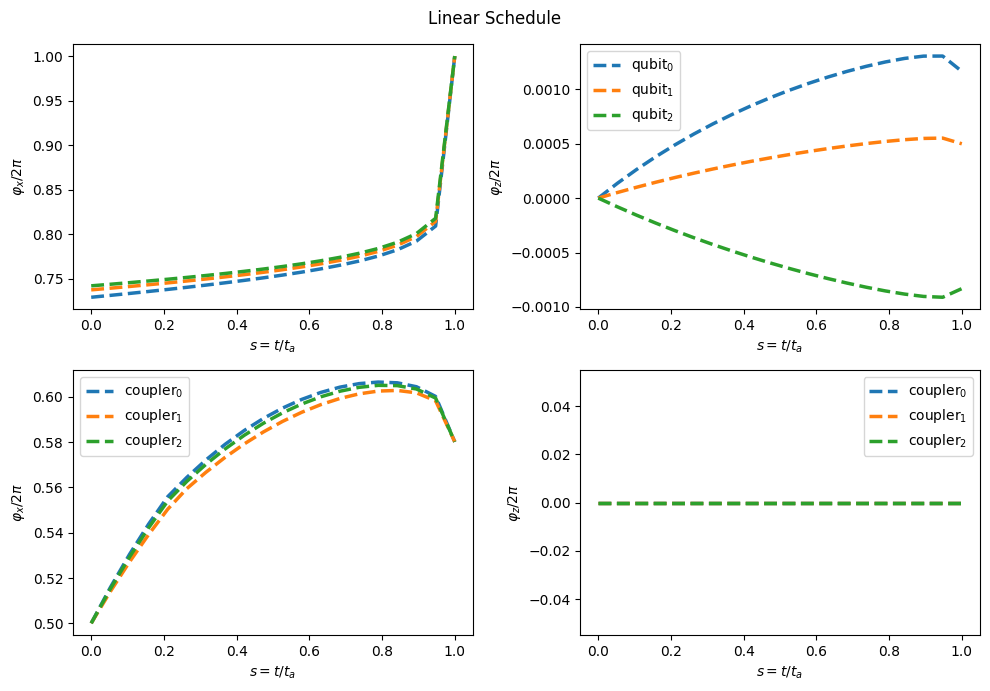

In [79]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((10, 7))

ax1 = plt.subplot(2, 2, 1)
s = ising_linear["s"]
print(circuit.qubit_indices)
for i, qubit_index in enumerate(circuit.qubit_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phix_"+str(qubit_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5, label=r"qubit$_{0:d}$".format(i),)
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")

ax2 = plt.subplot(2, 2, 2)
for i, qubit_index in enumerate(circuit.qubit_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phiz_"+str(qubit_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5, label=r"qubit$_{0:d}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend()
    
ax3 = plt.subplot(2, 2, 3)

for i, coupler_index in enumerate(circuit.coupler_indices):
    
    plt.plot(s, custom_flux_dict_pwsw["phix_"+str(coupler_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5, label=r"coupler$_{0:d}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend()
    
ax4 = plt.subplot(2, 2, 4)
for i, coupler_index in enumerate(circuit.coupler_indices):
    plt.plot(s, custom_flux_dict_pwsw["phiz_"+str(coupler_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5, label=r"coupler$_{0:d}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend()
    

plt.suptitle('Linear Schedule')
plt.tight_layout()
plt.show()

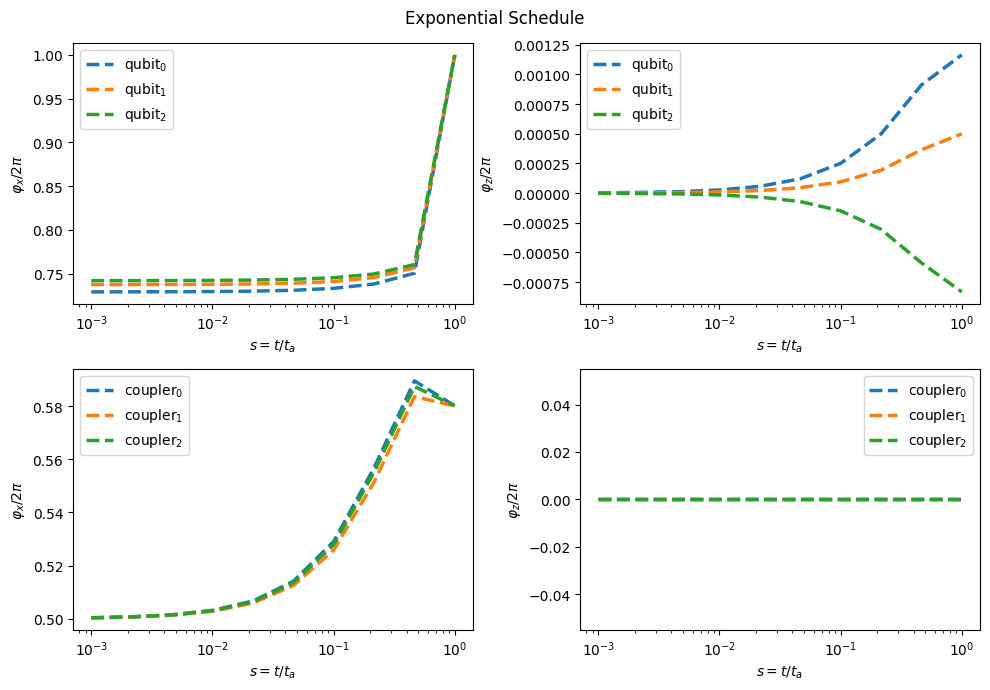

In [49]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((10, 7))

ax1 = plt.subplot(2, 2, 1)
s = ising_exponential["s"]
for i, qubit_index in enumerate(circuit.qubit_indices):
    

    plt.plot(s, custom_flux_dict_pwsw2["phix_"+str(qubit_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5, label=r"qubit$_{0:d}$".format(i),)
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.xscale('log')
    plt.legend()

ax2 = plt.subplot(2, 2, 2)
for i, qubit_index in enumerate(circuit.qubit_indices):
    
    plt.plot(s, custom_flux_dict_pwsw2["phiz_"+str(qubit_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5, label=r"qubit$_{0:d}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.xscale('log')
    plt.legend()
    
ax3 = plt.subplot(2, 2, 3)

for i, coupler_index in enumerate(circuit.coupler_indices):
    
    plt.plot(s, custom_flux_dict_pwsw2["phix_"+str(coupler_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5, label=r"coupler$_{0:d}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.xscale('log')
    plt.legend()
    
ax4 = plt.subplot(2, 2, 4)
for i, coupler_index in enumerate(circuit.coupler_indices):
    plt.plot(s, custom_flux_dict_pwsw2["phiz_"+str(coupler_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5, label=r"coupler$_{0:d}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.xscale('log')
    plt.legend()
    
plt.suptitle('Exponential Schedule')
plt.tight_layout()
plt.show()

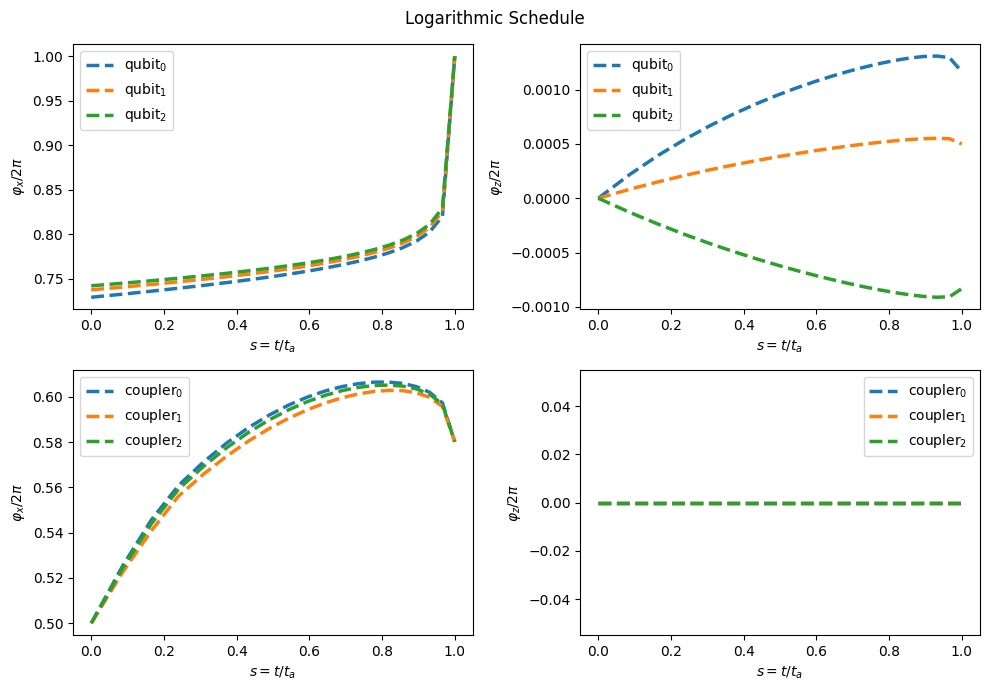

In [87]:
plt.clf();
fig = plt.figure(num=1);
fig.set_size_inches((10, 7))

ax1 = plt.subplot(2, 2, 1)
s = ising_logarithmic["s"]
for i, qubit_index in enumerate(circuit.qubit_indices):
    

    plt.plot(s, custom_flux_dict_pwsw3["phix_"+str(qubit_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5, label=r"qubit$_{0:d}$".format(i),)
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend()

ax2 = plt.subplot(2, 2, 2)
for i, qubit_index in enumerate(circuit.qubit_indices):
    
    plt.plot(s, custom_flux_dict_pwsw3["phiz_"+str(qubit_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5, label=r"qubit$_{0:d}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend()
    
ax3 = plt.subplot(2, 2, 3)

for i, coupler_index in enumerate(circuit.coupler_indices):
    
    plt.plot(s, custom_flux_dict_pwsw3["phix_"+str(coupler_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5, label=r"coupler$_{0:d}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_x/2\pi$")
    plt.legend()
    
ax4 = plt.subplot(2, 2, 4)
for i, coupler_index in enumerate(circuit.coupler_indices):
    plt.plot(s, custom_flux_dict_pwsw3["phiz_"+str(coupler_index)]/2/np.pi, '--', color="C{0:d}".format(i), lw=2.5, label=r"coupler$_{0:d}$".format(i))
    
    plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\varphi_z/2\pi$")
    plt.legend()
    
plt.suptitle('Logarithmic Schedule')
plt.tight_layout()
plt.show()

### With the obtain fluxes calculate the energy spectrum of the circuit

    Step 1. Define a function to get the spectrum from the flux schedule using the code from CAS

In [90]:
energies_lin = circuit.calculate_spectrum(custom_flux_dict_pwsw, levels=4)

In [91]:
energies_exp = circuit.calculate_spectrum(custom_flux_dict_pwsw2, levels=4)

In [81]:
energies_log = circuit.calculate_spectrum(custom_flux_dict_pwsw3, levels=4)

Minimum Gap E0: 0.00
Minimum Gap E1: 2.87
Minimum Gap E2: 4.92
Minimum Gap E3: 6.17


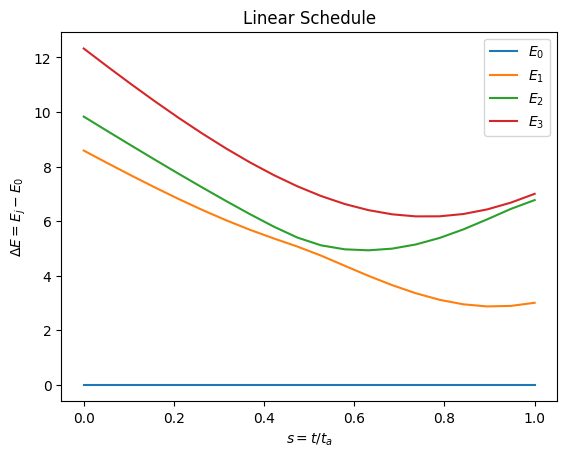

In [99]:
s = ising_linear["s"]
for i in range(4):
    energies_norm_i = np.array(energies_lin[:,i]) - np.array(energies_lin[:,0])
    print(f"Minimum Gap E{i}: {min(energies_norm_i):.2f}")
    plt.plot(s, energies_norm_i, label=fr"$E_{i}$")

plt.title('Linear Schedule')
plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\Delta E = E_{{j}} - E_{{0}}$")
plt.legend()



Minimum Gap E0: 0.00
Minimum Gap E1: 3.00
Minimum Gap E2: 5.01
Minimum Gap E3: 6.22


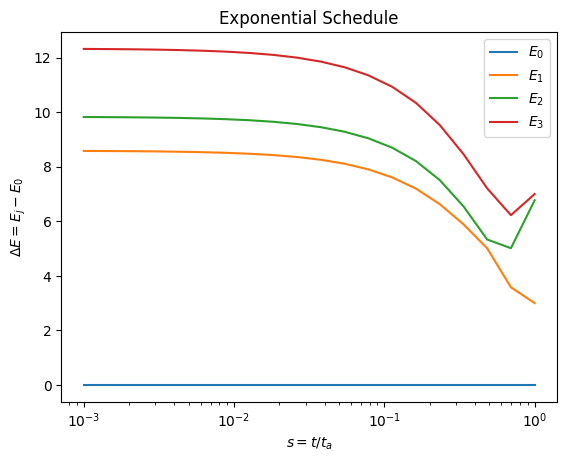

In [98]:
s = ising_exponential["s"]
for i in range(4):
    energies_norm_i = np.array(energies_exp[:,i]) - np.array(energies_exp[:,0])
    print(f"Minimum Gap E{i}: {min(energies_norm_i):.2f}")
    plt.plot(s, energies_norm_i, label=fr"$E_{i}$")

plt.title('Exponential Schedule')
plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\Delta E = E_{{j}} - E_{{0}}$")
plt.xscale('log')
plt.legend()


Minimum Gap E0: 0.00
Minimum Gap E1: 2.87
Minimum Gap E2: 4.93
Minimum Gap E3: 6.16


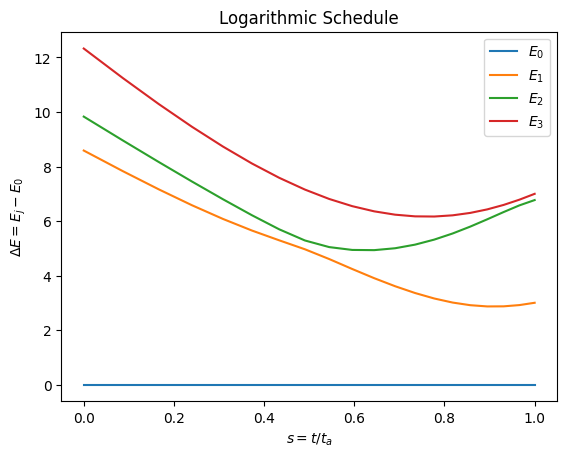

In [85]:
s = ising_logarithmic["s"]
for i in range(4):
    energies_norm_i = np.array(energies_log[:,i]) - np.array(energies_log[:,0])
    print(f"Minimum Gap E{i}: {min(energies_norm_i):.2f}")
    plt.plot(s, energies_norm_i, label=fr"$E_{i}$")

plt.title('Logarithmic Schedule')
plt.xlabel(r"$s=t/t_a$"); plt.ylabel(r"$\Delta E = E_{{j}} - E_{{0}}$")
#plt.xscale('log')
plt.legend()


In [47]:
s[1:] - s[0:-1]

array([0.00115443, 0.00248715, 0.00535841, 0.01154435, 0.02487154,
       0.05358411, 0.11544347, 0.24871541, 0.53584112])

### Research questions

1. For the annealing schedules calculated, do any of the resulting spectral schedules fulfill the adiabatic theorem?
2. By this point you will have obtained two energies, one from the software challenge (QAOA) and one from the annealing schedule above. Argue their relation.
3.  If you have made it here, you have problaly seen the difficulties of solving small instances. Can you propose ways to scale these procedures to more qubits? Some techniques for finding the gap along the annealing process can be found in [1], [2], [3] and [4]. Can you implement a simulation from one of these papers? Research and propose better techniques to find the flux schedule for a given Ising schedule with a greater amount of qubits.  

## Bibliography

[1] Adiabatic Spectroscopy and a Variational Quantum Adiabatic Algorithm: https://arxiv.org/abs/2103.01226

[2] Direct estimation of the energy gap between the ground state and excited state with quantum annealing: https://arxiv.org/abs/2007.10561

[3] Simulating quantum circuits by adiabatic computation: improved spectral gap bounds: https://arxiv.org/abs/1906.05233

[4] Spectroscopy on two coupled flux qubits: https://arxiv.org/abs/cond-mat/0308192

